## Data Analysis and Preparation for CF Book Recommender System 

### About the dataset
- Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.
- Oraganized into three CSV files, BX-Book-Ratings.csv, BX-Users.csv, BX_Books.csv
- Downloadable at https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset?resource=download-directory

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

In [22]:
# create file paths for each CSV file
file_path_Ratings = 'Book reviews/BX-Book-Ratings.csv'

# Load the CSV file into  DataFrames and handle errors
df_Ratings = pd.read_csv(file_path_Ratings, encoding='windows-1252', sep=';', on_bad_lines="skip")

# Display the first 5 rows of the DataFrames
df_Ratings.head()


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [23]:
file_path_Books = 'Book reviews/BX-Books.csv'
df_Books = pd.read_csv(file_path_Books, encoding='windows-1252',sep=';', on_bad_lines="skip")
df_Books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [24]:
file_path_Users = 'Book reviews/BX-Users.csv'
df_Users = pd.read_csv(file_path_Users,  encoding='windows-1252',sep=';', on_bad_lines="skip")
df_Users.head()


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### Some Data Analysis:

In [57]:
#ratings_count = len(df_Ratings)


# counting non-zero ratings
df_Ratings_no_zeros = df_Ratings.copy()
# Replace 0 values with NaN in the 'Book-Rating' column
df_Ratings_no_zeros['Book-Rating'] = df_Ratings_no_zeros['Book-Rating'].replace(0, np.nan)
# Drop rows with NaN values (which were 0 before)
df_Ratings_no_zeros = df_Ratings_no_zeros.dropna(subset=['Book-Rating'])

ratings_count = len(df_Ratings_no_zeros)
book_count = df_Ratings['ISBN'].nunique()
user_count = df_Ratings['User-ID'].nunique()

print(f"Number of ratings: {ratings_count}")
print(f"Number of unique books: {book_count}")
print(f"Number of unique users: {user_count}")
print(f"Average number of ratings per user: {round(ratings_count/user_count, 2)}")
print(f"Average number of ratings per book: {round(ratings_count/book_count, 2)}")

Number of ratings: 433671
Number of unique books: 340556
Number of unique users: 105283
Average number of ratings per user: 4.12
Average number of ratings per book: 1.27


In [64]:
# calculate mean ratings
print(f"Mean global rating: {round(df_Ratings_no_zeros['Book-Rating'].mean(),2)}")

user_mean_ratings = df_Ratings_no_zeros.groupby('User-ID')['Book-Rating'].mean()
book_mean_ratings = df_Ratings_no_zeros.groupby('ISBN')['Book-Rating'].mean()

print(f"Mean rating per user: {round(mean_ratings.mean(),2)}")
print(f"Mean rating per book: {round(book_mean_ratings.mean(),2)}")

Mean global rating: 7.6
Mean rating per user: 7.46
Mean rating per book: 7.49


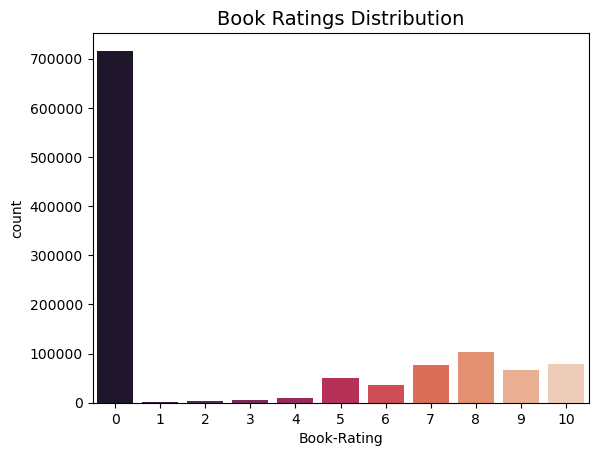

In [59]:
# plotting Book Ratings Distribution
sns.countplot(x="Book-Rating", data=df_Ratings, palette="rocket")
plt.title("Book Ratings Distribution", fontsize=14)
plt.show()


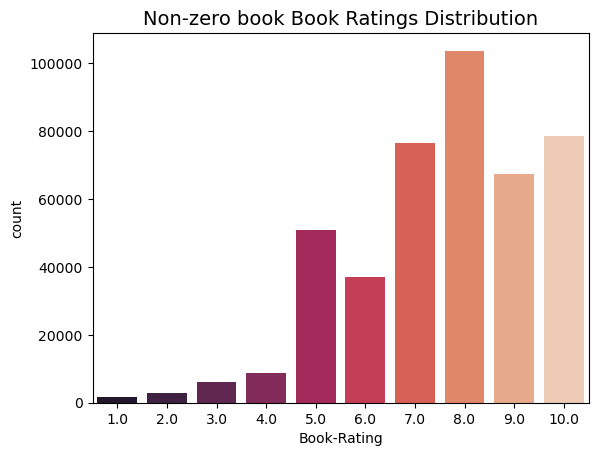

In [60]:
# plotting Non-zero Book Ratings Distribution
sns.countplot(x="Book-Rating", data=df_Ratings_no_zeros, palette="rocket")
plt.title("Non-zero book Book Ratings Distribution", fontsize=14)
plt.show()

In [77]:
def utility_matrix(df):
    """
    creates a sparse utility matrix from BX-Book-Ratings dataframe

    Args:
        df: pandas ratings dataframe containing 3 columns (User-ID, ISBN, Book-Rating)

    Returns:
        UMX: sparse matrix
        book_to_index: book to index mapper 
        user_to_index: user to index mapper 
        index_to_book: index to book mapper 
        index_to_user: index to user mapper
    """
    I = df['ISBN'].nunique() # count unique number of books
    J = df['User-ID'].nunique() # count unique number of users

    # MAPPERS
    # map each unique ISBN to a unique index
    book_to_index = dict(zip(np.unique(df["ISBN"]), list(range(I))))

    # map each unique User-ID to a unique index
    user_to_index = dict(zip(np.unique(df["User-ID"]), list(range(J))))

    
    # INVERSE MAPPERS
    # map each book index back to its ISBN
    index_to_book = dict(zip(list(range(I)), np.unique(df["ISBN"])))
    
    # map each user index back to its ID
    index_to_user = dict(zip(list(range(J)), np.unique(df["User-ID"])))

    # prepare the data to be placed in the sparse matrix
    book_index = [book_to_index[i] for i in df['ISBN']]
    user_index = [user_to_index[i] for i in df['User-ID']]

    # buil the sparse utility matrix
    UMX = csr_matrix((df["Book-Rating"], (book_index,user_index)), shape=(I,J))

    return UMX, book_to_index, user_to_index, index_to_book, index_to_user


In [78]:
UMX, book_to_index, user_to_index, index_to_book, index_to_user = utility_matrix(df_Ratings)

In [79]:
# sparsity of the matrix = # of non-zero elements / matrix size
print(f"Sparsity: {round(UMX.nnz / (UMX.shape[0]*UMX.shape[1]) *100,4)}%")

Sparsity: 0.0032%


#### References
Chong, D. (2021, September 24). Why we use sparse matrices for Recommender Systems. Medium. https://towardsdatascience.com/why-we-use-sparse-matrices-for-recommender-systems-2ccc9ab698a4 